# Feature Extraction

## Get the [Data](https://www.kaggle.com/datasets/vishweshsalodkar/wild-animals)

In [79]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [80]:
!pip install kaggle

In [81]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/MyDrive/wild-animals"

In [82]:
!kaggle datasets download -d vishweshsalodkar/wild-animals

wild-animals.zip: Skipping, found more recently modified local copy (use --force to force download)


In [83]:
import zipfile

# unzip the downloaded data
zip_ref = zipfile.ZipFile("/content/wild-animals.zip")
zip_ref.extractall()
zip_ref.close()

In [84]:
# inspect the data
!ls /content/Animals
animals_directory = "/content/Animals"

Cheetah  Jaguar  Leopard  Lion	Tiger


In [85]:
# get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(animals_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

In [86]:
print(class_names)

['Cheetah' 'Jaguar' 'Leopard' 'Lion' 'Tiger']


In [87]:
# visualize images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # setup the target directory
  target_folder = target_dir + "/" + target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # get 1
  print(random_image)

  # read the image and plot it
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

['photo-1486199149722-825253b06114.jpg']
Image shape: (742, 500, 3)


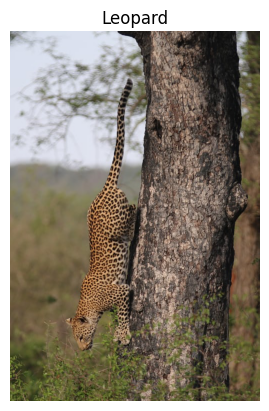

In [88]:
# visualize
import random
img = view_random_image(target_dir = animals_directory,
                        target_class = random.choice(class_names))

## Preprocess the data

In [89]:
# set data inputs
import tensorflow as tf

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(animals_directory,
                                                                 validation_split = 0.2,
                                                                 seed=1,
                                                                 subset = "training",
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMG_SIZE) # set as training data

test_data = tf.keras.preprocessing.image_dataset_from_directory(animals_directory,
                                                                 validation_split = 0.2,
                                                                 seed=1,
                                                                 subset = "validation",
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMG_SIZE) # set as validation data

Found 170 files belonging to 5 classes.
Using 136 files for training.
Found 170 files belonging to 5 classes.
Using 34 files for validation.


## Data Augmentation

In [90]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescale(1./255), we do not use it because EfficientNet has rescaling built-in
    # preprocessing.Resize(IMG_SIZE, IMG_SIZE)
], name = "data_augmentation")

## Building Model

In [91]:
# setup input shape to the model
input_shape = (256, 256, 3)

# create a frozen base model
base_model = tf.keras.applications.EfficientNetB4(include_top = False)
base_model.trainable = False

# create the inputs and outputs (including the layer in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
# apply data augmentation
x = data_augmentation(inputs)

x = base_model(x, training = False) # training = False because, we pass augmented images but keep it in inference mode (training turn off, weights and batchnorm layers dont get updated)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)

outputs = layers.Dense(5, activation = "softmax", name = "output_layers")(x)

model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [92]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_2D (  (None, 1792)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layers (Dense)       (None, 5)                 8965      
                                                                 
Total params: 17,682,788
Trainable params: 8,965
Non-traina

## Creating Model Checkpoint Callback

In [93]:
# Set checkpoint_path
checkpoint_path = "/content/gdrive/MyDrive/wild-animals/checkpoint.ckpt"

# create a ModelCheckpoint Callback that saves the model weight's only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                          save_weights_only = True,
                                                          save_best_only = False,
                                                          save_freq = "epoch", # save every epoch
                                                          verbose = 1)

## Fit the Model

In [94]:
# Fit the model saving checkpoints every epoch
initial_epoch = 5

history_1 = model_1.fit(train_data,
                        epochs = initial_epoch,
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks = [checkpoint_callback])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 1.5691 - accuracy: 0.3162
Epoch 1: saving model to /content/gdrive/MyDrive/wild-animals/checkpoint.ckpt
5/5 [==============================] - 31s 2s/step - loss: 1.5691 - accuracy: 0.3162 - val_loss: 1.2816 - val_accuracy: 0.8235
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.2456 - accuracy: 0.6765
Epoch 2: saving model to /content/gdrive/MyDrive/wild-animals/checkpoint.ckpt
5/5 [==============================] - 6s 1s/step - loss: 1.2456 - accuracy: 0.6765 - val_loss: 1.0180 - val_accuracy: 0.9118
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 1.0143 - accuracy: 0.7868
Epoch 3: saving model to /content/gdrive/MyDrive/wild-animals/checkpoint.ckpt
5/5 [==============================] - 5s 842ms/step - loss: 1.0143 - accuracy: 0.7868 - val_loss: 0.8180 - val_accuracy: 0.9118
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 0.8354 - accuracy: 0.8603
Epoch 4: saving mode

In [95]:
model_1.evaluate(test_data)

2/2 [==============================] - 0s 34ms/step - loss: 0.5538 - accuracy: 0.9118


[0.5537571907043457, 0.9117646813392639]

## Loading in checkpointed weights

In [96]:
checkpoint_path

'/content/gdrive/MyDrive/wild-animals/checkpoint.ckpt'

In [97]:
# Load in saved model weights and evaluate
model_1.load_weights(checkpoint_path)

In [98]:
# Evaluate the Model with the loaded weight
loaded_weights_model_results = model_1.evaluate(test_data)

2/2 [==============================] - 0s 34ms/step - loss: 0.5538 - accuracy: 0.9118


# Fine-tuning

In [99]:
# Layers in Loaded model
model_1.layers

In [100]:
# Are these layers trainable?
for layer in model_1.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7d2f16bab970> True
<keras.engine.sequential.Sequential object at 0x7d2f204a2f80> True
<keras.engine.functional.Functional object at 0x7d303ffd3820> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7d303fef6380> True
<keras.layers.core.dense.Dense object at 0x7d303fe6b7c0> True


<keras.engine.functional.Functional object at 0x7d2f25b8ae90> is our base model

In [101]:
# What layers in our base model (EfficientNetB4) and are they trainable?
for i, layer in enumerate(model_1.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [102]:
# How many trainable variables are in our base model?
print(len(model_1.layers[2].trainable_variables))

0


In [103]:
# To begin fine-tuning, setting the last 10 layers of our base_model.trainable = True
# set all True first
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (every time we make a change)
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # it will be better lower the learning rate by (the general rule is by 10x), because these layers have learned some patterns on an existing dataset before, and we do not want to drastically change those patterns because overfitting could be happened,
                metrics = ["accuracy"])

In [104]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [105]:
# We have unfrozen some of layers closer to the top, how many trainable variables are in our base_model now?
print(len(model_1.layers[2].trainable_variables))

10


In [106]:
history_1.epoch[-1]

4

In [107]:
# Fine tune another 5 epochs
fine_tune_epochs = initial_epoch + 5

# refit the model
history_fine_tune = model_1.fit(train_data,
                                epochs = fine_tune_epochs,
                                validation_data = test_data,
                                validation_steps = len(test_data),
                                # because we already fit 5 epochs in model_1 before (usingsaved model_1's weights), and want more 5 epochs for fine-tuning
                                initial_epoch = history_1.epoch[-1]) # start training from preveious last epoch

Epoch 5/10
5/5 [==============================] - 24s 2s/step - loss: 0.6512 - accuracy: 0.8162 - val_loss: 0.4368 - val_accuracy: 0.9118
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.5238 - accuracy: 0.8235 - val_loss: 0.3707 - val_accuracy: 0.8529
Epoch 7/10
5/5 [==============================] - 5s 860ms/step - loss: 0.4566 - accuracy: 0.8382 - val_loss: 0.3266 - val_accuracy: 0.8529
Epoch 8/10
5/5 [==============================] - 5s 772ms/step - loss: 0.4217 - accuracy: 0.8603 - val_loss: 0.2980 - val_accuracy: 0.8529
Epoch 9/10
5/5 [==============================] - 4s 730ms/step - loss: 0.4047 - accuracy: 0.8603 - val_loss: 0.2725 - val_accuracy: 0.9118
Epoch 10/10
5/5 [==============================] - 4s 699ms/step - loss: 0.3385 - accuracy: 0.9044 - val_loss: 0.2610 - val_accuracy: 0.9118


In [108]:
# Evaluate the fine-tuned model
results_fine_tune = model_1.evaluate(test_data)

2/2 [==============================] - 0s 29ms/step - loss: 0.2610 - accuracy: 0.9118


In [109]:
# Function to compare training histories
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Loss")

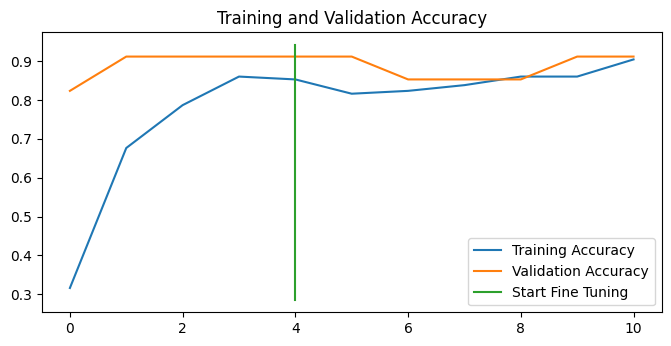

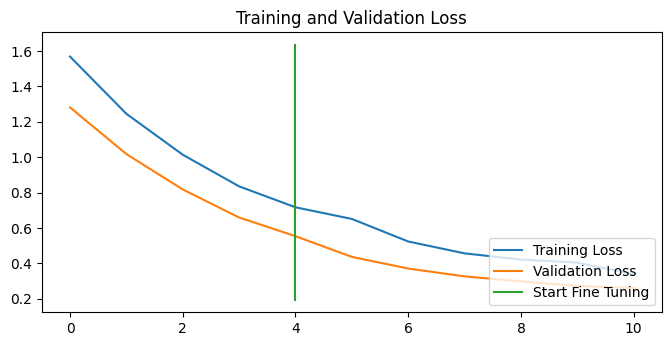

In [110]:
compare_historys(history_1,
                 history_fine_tune,
                 initial_epochs = 5)